In [19]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize

from tqdm import tqdm

from mask_width_detection import mask_width_detection
import find_branch
import subpixel_edge
from polynomial_regression import polynomial_regression, cal_polynomial
from sort_points import sort_points
from vectorization import vessel_vector
from hermite_spline import fit, get_lines, differentiate
from sampling import simple_sampling, delete_outliers

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
img_path = "../data/img/039_img.png"
mask_path = "../data/mask/039_mask.png"
param_w = [1]
solver_type = 'dn'
max_num_iterations = 100
ratio = 0.5
min_radius = 1e-9
max_radius = 1e12
num_samples = 1024
initial_radius = 1e4
degree = 2
dim= 2
num_init_points = 32

file = {}

In [21]:
#이미지 로드
mask = np.array(Image.open(mask_path))
mask_r = mask[:,:,0]
mask_b = mask[:,:,2]
img = np.array(Image.open(img_path))
blur_img = cv2.GaussianBlur(img[:,:,1], (5,5), 3)

In [22]:
#스켈레톤
skeleton_img = skeletonize(mask, method='lee')
skeleton_r = skeleton_img[:,:,0]
skeleton_b = skeleton_img[:,:,2]

#분기점 
junction_coor_r = np.where(find_branch.find_branch_points(skeleton_r > 0))
junction_coor_b = np.where(find_branch.find_branch_points(skeleton_b > 0))


#분기점 제거및 마스크 추출
center_r = []
for i in tqdm(range(len(junction_coor_r[0]))):
    jx = junction_coor_r[0][i]
    jy = junction_coor_r[1][i]
    center_r.append([jx, jy])
    branch_mask = find_branch.find_branch_mask(mask_r,jy,jx)
    S = branch_mask.shape[0]//2
    skeleton_r[jx-S:jx+S+1, jy-S:jy+S+1] = 0
    

center_b = []
for i in tqdm(range(len(junction_coor_b[0]))):
    jx = junction_coor_b[0][i]
    jy = junction_coor_b[1][i]
    center_b.append([jx, jy])
    skeleton_b[jx-1:jx+2, jy-1:jy+2] = 0
    branch_mask = find_branch.find_branch_mask(mask_b,jy,jx)
    S = branch_mask.shape[0]//2
    skeleton_b[jx-S:jx+S+1, jy-S:jy+S+1] = 0

100%|██████████| 182/182 [00:00<00:00, 1188.66it/s]


In [23]:
#vertex 분리
retvals_r, labels_r, stats_r, _ = cv2.connectedComponentsWithStats(skeleton_r)
retvals_b, labels_b, stats_b, _ = cv2.connectedComponentsWithStats(skeleton_b)

In [24]:
def draw_line(mask, point1, point2, color='r', thickness=2):
    # 이미지의 크기를 확인하여 선의 좌표를 유효 범위로 조정합니다.
    height, width = mask.shape[:2]
    point1 = np.clip(point1, [0, 0], [width-1, height-1])
    point2 = np.clip(point2, [0, 0], [width-1, height-1])

    # 선의 좌표를 이용하여 직선 방정식을 구합니다.
    x_values = np.linspace(point1[0], point2[0], num=100)
    y_values = np.linspace(point1[1], point2[1], num=100)

    # 굵기에 따라 선을 그립니다.
    if color == 'r':
        for i in range(-thickness // 2, thickness // 2 + 1):
            mask[np.round(y_values + i).astype(int), np.round(x_values).astype(int),0] = 0
    elif color == 'b':
        for i in range(-thickness // 2, thickness // 2 + 1):
            mask[np.round(y_values).astype(int), np.round(x_values + i).astype(int),2] = 0


100%|██████████| 309/309 [00:03<00:00, 81.06it/s] 


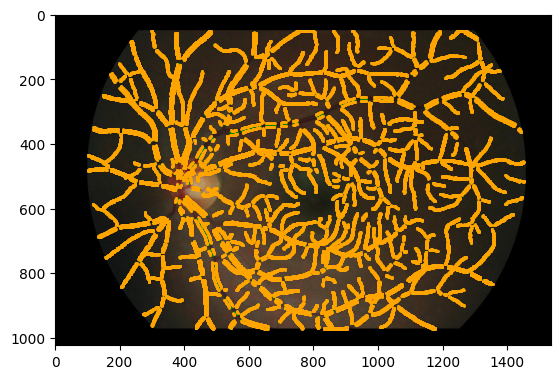

In [25]:
vessel_informs = [(retvals_r,labels_r,mask[:,:,0],'r'),(retvals_b,labels_b,mask[:,:,2],'b')]

sub_edge_x = []
sub_edge_y = []

center_x = []
center_y = []

sampling_num = 2

branch_mask = mask.copy()

plt.imshow(img)
for vessel in vessel_informs:
    for i in tqdm(range(1,vessel[0])):
        target_line = (vessel[1] == i).copy()
        sorted_x,sorted_y = sort_points(target_line)

        #spline
        spline = fit(sorted_x, sorted_y, 1.5)
        x = get_lines(spline[0],sampling_num)
        y = get_lines(spline[1],sampling_num)

        edge_x, edge_x2, edge_y, edge_y2 = mask_width_detection(vessel[2],np.c_[x,y])

        if len(edge_x) > 2:
            draw_line(branch_mask, (edge_y[0],edge_x[0]), (edge_y2[0],edge_x2[0]), color = vessel[3])
            draw_line(branch_mask, (edge_y[-1],edge_x[-1]), (edge_y2[-1],edge_x2[-1]), color = vessel[3])

        #sampling edge point
        edge_x = simple_sampling(edge_x, 2)
        edge_y = simple_sampling(edge_y, 2)
        edge_x2 = simple_sampling(edge_x2, 2)
        edge_y2 = simple_sampling(edge_y2, 2)

        x_cen = (edge_x+edge_x2)/2
        y_cen = (edge_y+edge_y2)/2
        center_tan = (edge_y - edge_y2)/(edge_x-edge_x2+1e-12)
        vessel_w = np.sqrt((edge_y - edge_y2)**2+(edge_x-edge_x2)**2)/2

        subcen_x = np.array([])
        subcen_y = np.array([])
        r = np.array([])

        #subpixel_localization
        for i in range(len(x_cen)):
            a,b = subpixel_edge.get_edge(blur_img,(x_cen[i],y_cen[i]), center_tan[i],vessel_w[i],radius_edge_width_ratio = 4/vessel_w[i], sampling_num = 50, power_factor = 2)
            subcen_x = np.append(subcen_x, (a[0]+b[0])/2)
            subcen_y = np.append(subcen_y, (a[1]+b[1])/2)
            r = np.append(r, np.sqrt((a[1] - b[1])**2+(a[0]-b[0])**2)/2)

        sampling_num = 2

        sub_spline = fit(subcen_x,subcen_y,5)
        spline_x = get_lines(sub_spline[0],sampling_num)#.clip(0,mask.shape[1]-1)
        spline_y = get_lines(sub_spline[1],sampling_num)#.clip(0,mask.shape[0]-1)
        spline_diff_x = differentiate(sub_spline[0])
        spline_diff_y = differentiate(sub_spline[1])
        spline_diff_poly = []
        for i in range(len(spline_diff_x)):
            spline_diff_poly.append(spline_diff_y[i]/(spline_diff_x[i] + 1e-9)) 
        spline_diff = get_lines(spline_diff_poly,sampling_num)

        
        a = np.arange(0,len(r),1)
        r_spline = fit(a,r,5)

        spline_r = get_lines(r_spline[1],sampling_num)

        
        if len(spline_x) < 5:
            continue

        spline_x, spline_y, spline_r, spline_diff = delete_outliers(spline_x, spline_y, spline_r, spline_diff , 2)

        angle = np.arctan(spline_diff) + np.pi/2

        cal_x = np.array(spline_x) + spline_r * np.cos(np.array(angle))
        cal_y = np.array(spline_y) + spline_r * np.sin(np.array(angle))
        cal_x1 = np.array(spline_x) + spline_r * np.cos(np.array(angle)+np.pi)
        cal_y1 = np.array(spline_y) + spline_r * np.sin(np.array(angle)+np.pi)

        center_x += spline_x.tolist()
        center_y += spline_y.tolist()

        sub_edge_x += cal_x.tolist()
        sub_edge_y += cal_y.tolist()
        sub_edge_x += cal_x1.tolist()
        sub_edge_y += cal_y1.tolist()

        

    plt.scatter(center_y, center_x, c = 'g', s = 1)

    plt.scatter(sub_edge_y,sub_edge_x, c = 'orange', s = 1)

plt.show()

In [26]:
retvals_r, labels_r, stats_r, _ = cv2.connectedComponentsWithStats(branch_mask[:,:,0])
retvals_b, labels_b, stats_b, _ = cv2.connectedComponentsWithStats(branch_mask[:,:,2])

In [27]:
mask_edge = np.zeros_like(mask)
for pts in center_r:
    label = labels_r[int(pts[0]),int(pts[1])]
    if id != 0 and (labels_r==label).sum() < 400:
        branch_edge = (labels_r==label).astype(np.uint8)*255
        kernel = np.ones((3, 3), np.uint8)
        kernel[0,0] = 0
        kernel[0,2] = 0
        kernel[2,0] = 0
        kernel[2,2] = 0
        dilated_mask = cv2.dilate(branch_edge, kernel, iterations=1)
        dilated_mask *= (mask[:,:,0]==0)
        mask_edge[:,:,0] += dilated_mask

for pts in center_b:
    label = labels_b[int(pts[0]),int(pts[1])]
    if id != 0 and (labels_b==label).sum() < 400:
        branch_edge = (labels_b==label).astype(np.uint8)*255
        kernel = np.ones((3, 3), np.uint8)
        kernel[0,0] = 0
        kernel[0,2] = 0
        kernel[2,0] = 0
        kernel[2,2] = 0
        dilated_mask = cv2.dilate(branch_edge, kernel, iterations=1)
        dilated_mask *= (mask[:,:,2]==0)
        mask_edge[:,:,2] += dilated_mask

In [32]:
edge_r = np.where(mask_edge[:,:,0] > 0)
edge_b = np.where(mask_edge[:,:,2] > 0)

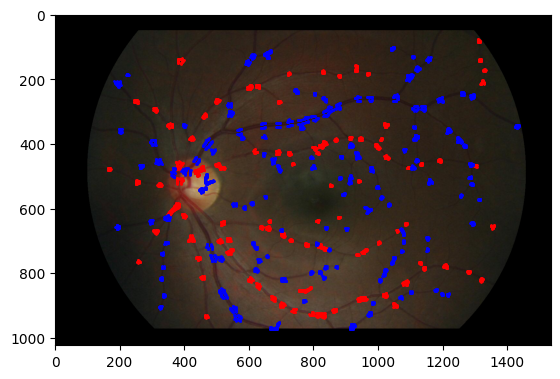

In [33]:
plt.imshow(img)
plt.scatter(edge_r[1],edge_r[0], c = 'r', s = 1)
plt.scatter(edge_b[1],edge_b[0], c = 'b', s = 1)
plt.show()